### Bước 1: Tải Dataset từ Kaggle
- Trong bài toán này sẽ làm về bài toán phân loại 3 loại giầy, dép là: shoe, sandal, boot

# Install kaggle 

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Tải dataset từ kaggle về colab

In [ ]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip -q /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip

 98% 46.0M/47.0M [00:03<00:00, 22.4MB/s]
100% 47.0M/47.0M [00:03<00:00, 15.3MB/s]


### Bước 2: Tạo Train-data và Test-data từ Dataset vừa tải về

# Import các thư viện cần dùng

In [ ]:
from keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# Visualize Dataset

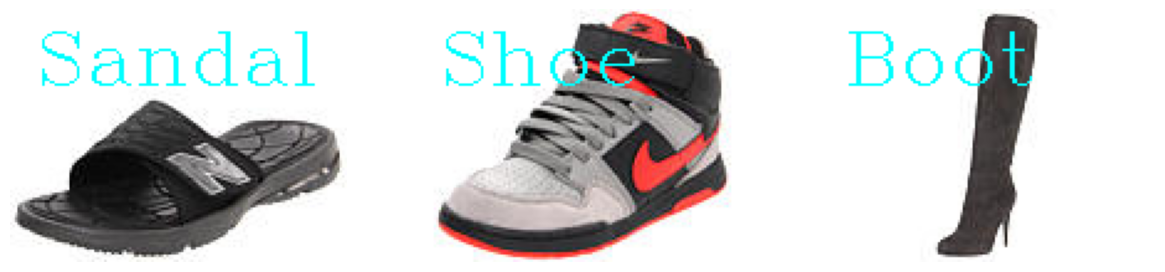

In [ ]:
path_dataset = '/content/Shoe vs Sandal vs Boot Dataset'
folders = os.listdir(path_dataset)
plt.figure(figsize=(20, 20))
for count, folder in enumerate(folders):
    images = os.listdir(f'{path_dataset}/{folder}')
    image = np.random.choice(images)

    img = cv2.imread(f'{path_dataset}/{folder}/{image}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.putText(img, folder, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 255), 1)

    plt.subplot(5, 4, count+1)
    plt.imshow(img)
    plt.axis('off')

# chia Dataset thành train_data và validation_data
- Ảnh được đưa về kích thước 64x64
- Với batch_size = 32

In [ ]:
# Set-up ImageDataGenerator để làm giàu ảnh
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip = True,
    validation_split=0.1, 
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    path_dataset,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    path_dataset,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical',
    subset='validation'
) 

Found 13500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
# chia train_generator thành train_data, test_data
train_data, test_data = train_test_split(train_generator, test_size=0.1)

# Thử xem ảnh đầu tiên trong bộ train

In [ ]:
image, label = next(iter(train_generator))

[0. 1. 0.]


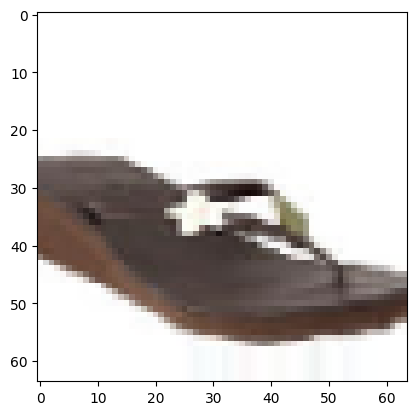

In [ ]:
print(label[0])
plt.imshow(image[0])

### Bước 3: Xây dựng model

## 3.1 Xây dựng model từ keras

In [ ]:
model_0 = Sequential()
model_0.add(Conv2D(8, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_0.add(MaxPool2D(2, 2))
model_0.add(Conv2D(16, (3, 3), activation='relu'))
model_0.add(MaxPool2D(2, 2))
model_0.add(Conv2D(32, (3, 3), activation='relu'))
model_0.add(MaxPool2D(2, 2))

model_0.add(Flatten())
model_0.add(Dense(512, activation='relu'))
model_0.add(Dense(64, activation='relu'))
model_0.add(Dense(len(folders), activation='softmax'))

model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 32)        

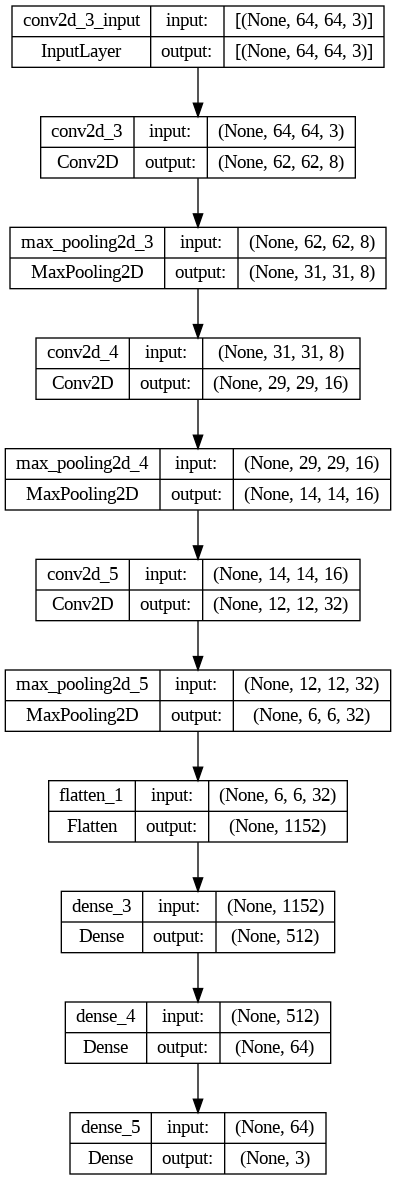

In [ ]:
# show cấu trúc model
plot_model(model_0, to_file=('model_0.png'), show_shapes=True, show_layer_names=True)

# Train model

In [ ]:
# Create callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 3,
                                        mode='min', restore_best_weights=True)

model_0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_0_results = model_0.fit(train_generator,epochs=10, validation_data=validation_data, 
                              steps_per_epoch = 379,
                              validation_steps=47,
                              callbacks=[early_stopping_callback])

Epoch 1/10
379/379 [==============================] - 37s 71ms/step - loss: 0.4672 - accuracy: 0.8033 - val_loss: 0.3262 - val_accuracy: 0.8733
Epoch 2/10
379/379 [==============================] - 26s 67ms/step - loss: 0.2520 - accuracy: 0.9075 - val_loss: 0.2240 - val_accuracy: 0.9093
Epoch 3/10
379/379 [==============================] - 26s 68ms/step - loss: 0.1974 - accuracy: 0.9290 - val_loss: 0.1489 - val_accuracy: 0.9453
Epoch 4/10
379/379 [==============================] - 26s 68ms/step - loss: 0.1638 - accuracy: 0.9419 - val_loss: 0.1085 - val_accuracy: 0.9567
Epoch 5/10
379/379 [==============================] - 26s 69ms/step - loss: 0.1462 - accuracy: 0.9466 - val_loss: 0.1632 - val_accuracy: 0.9393
Epoch 6/10
379/379 [==============================] - 27s 70ms/step - loss: 0.1349 - accuracy: 0.9508 - val_loss: 0.1253 - val_accuracy: 0.9527
Epoch 7/10
379/379 [==============================] - 26s 69ms/step - loss: 0.1146 - accuracy: 0.9594 - val_loss: 0.1276 - val_accuracy:

In [ ]:
# Lưu model_0
model_0.save('model_0.h5')

# Plot loss and accuracy

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
  model_training_history: loss and accuracy
  metric_name_1: ten chi so 1
  metric_name_2: ten chi so 2
  plot_name: name of title
  '''

  # get metric
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # so luong lam truc x
  epochs = range(len(metric_value_1))

  # plot and graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # add title
  plt.title(str(plot_name))

  # add legend
  plt.legend()

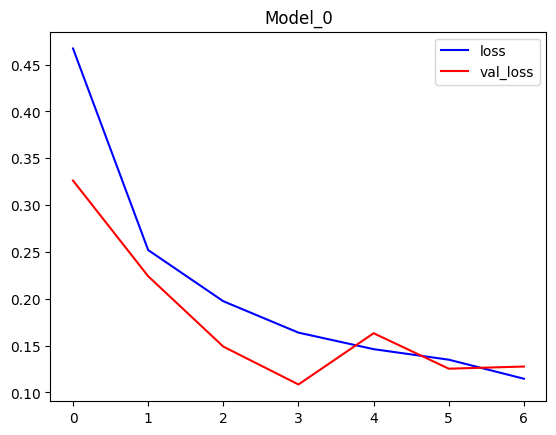

In [ ]:
# visualize the train and validation loss metrics
plot_metric(model_0_results, 'loss', 'val_loss', 'Model_0')

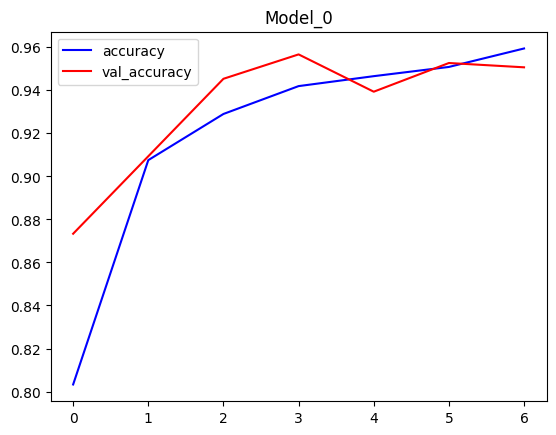

In [ ]:
plot_metric(model_0_results, 'accuracy', 'val_accuracy', 'Model_0')

## 3.2 Pre-train model Resnet-50

In [ ]:
from keras.applications import ResNet50
base_resnet = ResNet50(input_shape = (64, 64, 3),
                      include_top=False,
                       weights="imagenet")
base_resnet.trainable = False

In [ ]:
model_1 = Sequential()
model_1.add(base_resnet)
model_1.add(Flatten())
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(3, activation='softmax'))
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_30 (Dense)            (None, 1024)              8389632   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dense_32 (Dense)            (None, 64)                32832     
                                                                 
 dropout_13 (Dropout)        (None, 64)               

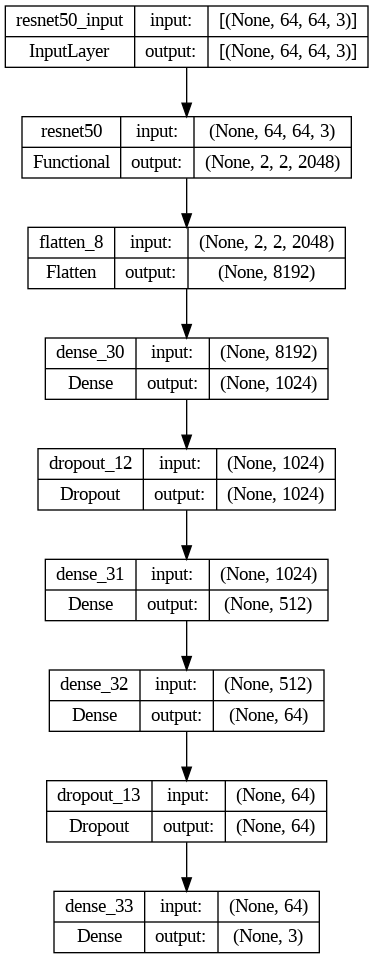

In [ ]:
# show cấu trúc model
plot_model(model_1, to_file=('model_1.png'), show_shapes=True, show_layer_names=True)

In [ ]:
# Create callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 3,
                                        mode='min', restore_best_weights=True)

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_1_results = model_1.fit(train_generator,epochs=10, validation_data=validation_data, 
                              steps_per_epoch = 379,
                              validation_steps=47,
                              callbacks=[early_stopping_callback])

Epoch 1/10
379/379 [==============================] - 39s 89ms/step - loss: 0.7819 - accuracy: 0.6147 - val_loss: 0.5265 - val_accuracy: 0.7420
Epoch 2/10
379/379 [==============================] - 32s 85ms/step - loss: 0.6272 - accuracy: 0.7085 - val_loss: 0.4914 - val_accuracy: 0.7733
Epoch 3/10
379/379 [==============================] - 31s 83ms/step - loss: 0.5804 - accuracy: 0.7446 - val_loss: 0.5034 - val_accuracy: 0.7887
Epoch 4/10
379/379 [==============================] - 34s 89ms/step - loss: 0.5584 - accuracy: 0.7606 - val_loss: 0.4769 - val_accuracy: 0.8087
Epoch 5/10
379/379 [==============================] - 32s 83ms/step - loss: 0.5274 - accuracy: 0.7737 - val_loss: 0.4237 - val_accuracy: 0.8287
Epoch 6/10
379/379 [==============================] - 34s 89ms/step - loss: 0.5211 - accuracy: 0.7791 - val_loss: 0.4326 - val_accuracy: 0.8120
Epoch 7/10
379/379 [==============================] - 31s 83ms/step - loss: 0.5229 - accuracy: 0.7787 - val_loss: 0.4077 - val_accuracy:

In [ ]:
model_1.save('model_1.h5')

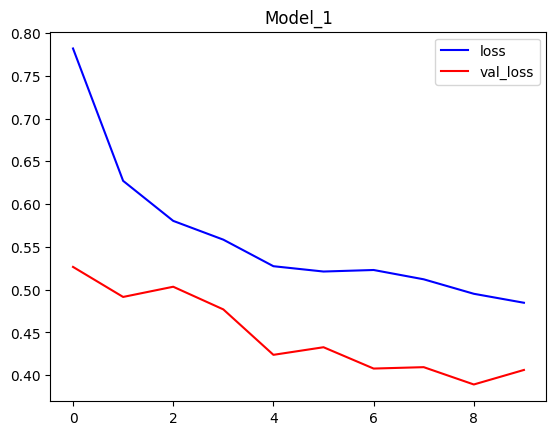

In [ ]:
# visualize the train and validation loss metrics
plot_metric(model_1_results, 'loss', 'val_loss', 'Model_1')

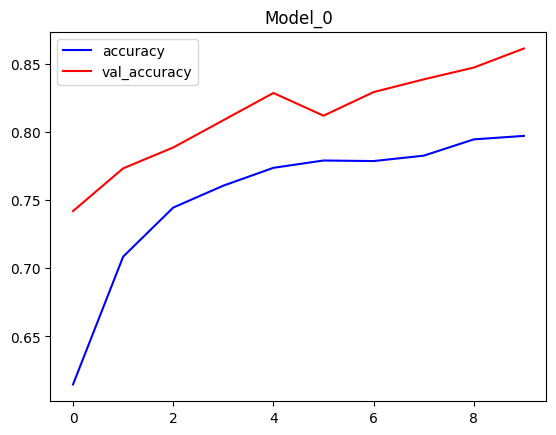

In [ ]:
plot_metric(model_1_results, 'accuracy', 'val_accuracy', 'Model_0')

## 3.2 Pre-Trained model vgg16

In [ ]:
from keras.applications import VGG16

base_vgg = VGG16(input_shape=(64, 64, 3),
                 include_top=False,
                 weights="imagenet")
base_vgg.trainable=False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model_2 = Sequential()
model_2.add(base_vgg)
model_2.add(Flatten())
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(3, activation='softmax'))
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dense_28 (Dense)            (None, 64)                32832     
                                                                 
 dropout_11 (Dropout)        (None, 64)               

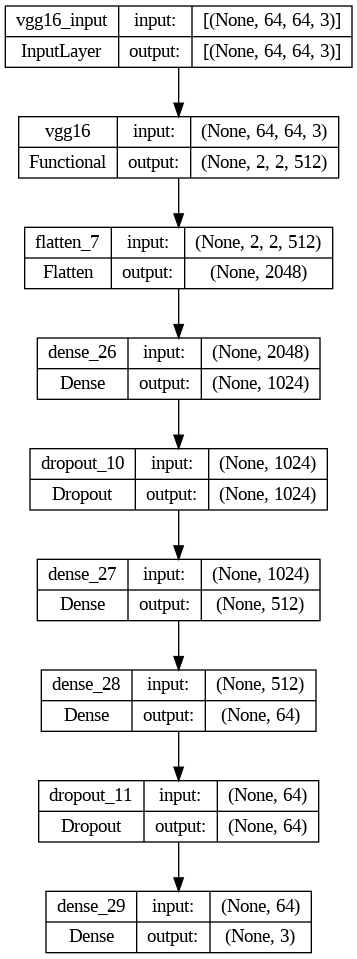

In [ ]:
# show cấu trúc model
plot_model(model_2, to_file=('model_2.png'), show_shapes=True, show_layer_names=True)

In [ ]:
# Create callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 3,
                                        mode='min', restore_best_weights=True)

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2_results = model_2.fit(train_generator,epochs=10, validation_data=validation_data, 
                              steps_per_epoch = 379,
                              validation_steps=47,
                              callbacks=[early_stopping_callback])

Epoch 1/10
379/379 [==============================] - 33s 82ms/step - loss: 0.4586 - accuracy: 0.8186 - val_loss: 0.3016 - val_accuracy: 0.8900
Epoch 2/10
379/379 [==============================] - 30s 80ms/step - loss: 0.3025 - accuracy: 0.8899 - val_loss: 0.1888 - val_accuracy: 0.9233
Epoch 3/10
379/379 [==============================] - 32s 84ms/step - loss: 0.2739 - accuracy: 0.9033 - val_loss: 0.1895 - val_accuracy: 0.9280
Epoch 4/10
379/379 [==============================] - 32s 85ms/step - loss: 0.2591 - accuracy: 0.9086 - val_loss: 0.1882 - val_accuracy: 0.9293
Epoch 5/10
379/379 [==============================] - 33s 88ms/step - loss: 0.2391 - accuracy: 0.9140 - val_loss: 0.2056 - val_accuracy: 0.9267
Epoch 6/10
379/379 [==============================] - 31s 82ms/step - loss: 0.2286 - accuracy: 0.9179 - val_loss: 0.1848 - val_accuracy: 0.9420
Epoch 7/10
379/379 [==============================] - 33s 86ms/step - loss: 0.2192 - accuracy: 0.9240 - val_loss: 0.1840 - val_accuracy:

In [ ]:
model_2.save('model_2.h5')

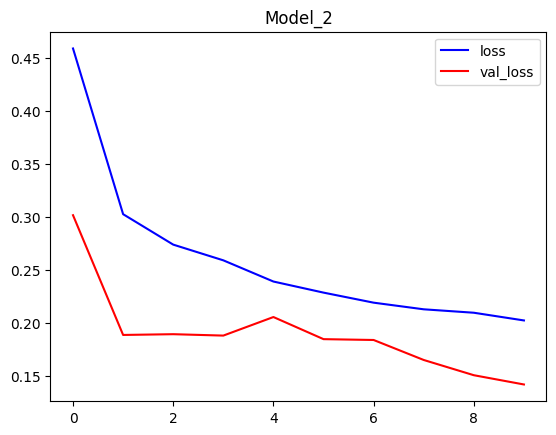

In [ ]:
plot_metric(model_2_results, 'loss', 'val_loss', 'Model_2')

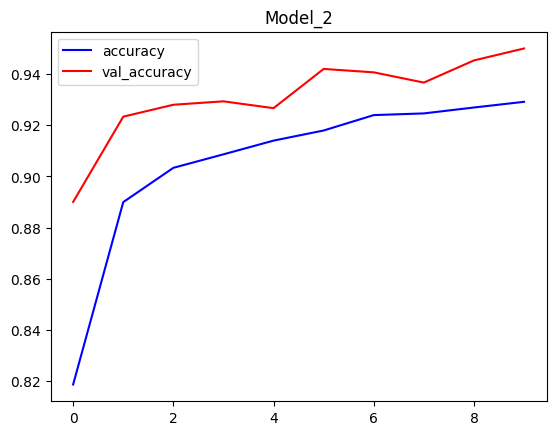

In [ ]:
plot_metric(model_2_results, 'accuracy', 'val_accuracy', 'Model_2')